<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250716/k%E3%83%A1%E3%83%87%E3%82%A3%E3%82%A2%E3%83%B3%E5%95%8F%E9%A1%8C%E3%81%AE%E6%BC%94%E7%BF%92%E5%95%8F%E9%A1%8C%E3%81%AE%E8%A7%A3%E8%AA%AC%E3%81%A8%E8%A7%A3%E7%AD%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **k-メディアン問題 演習問題 解答・解説**

### **ライブラリのインストールとインポート**
`python-mip` ライブラリと、グラフ描画時に日本語を表示するための `japanize-matplotlib` をインストール

In [1]:
%%capture
# python-mip ライブラリをインストールする
!pip install mip

# Matplotlibで日本語を表示するためのライブラリをインストール
!pip install japanize-matplotlib

# 必要なライブラリをインポートする
import mip
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib # 日本語表示のためにインポート
import random
from scipy.spatial.distance import cdist # 距離行列計算用

### **例題データの設定**
全ての演習問題で基準となる、15個の需要地点（兼施設候補地）の例題のデータを作成する。
座標はランダムに生成し、地点間の距離はユークリッド距離で計算する。

総地点数（需要地点/施設候補地）: 15
座標データとユークリッド距離行列の準備が完了しました。


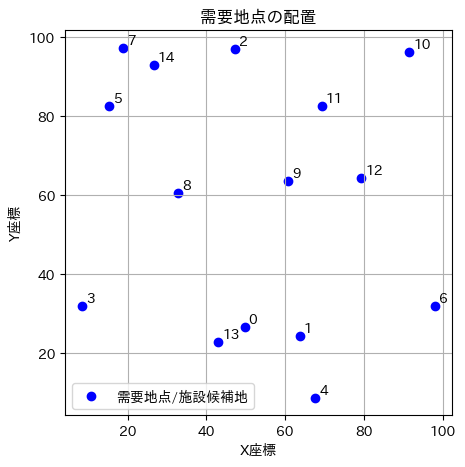

In [2]:
# 地点数 (需要地点数 = 施設候補地数)
num_locations = 15 # 例として15地点
k_to_locate = 3    # 開設する施設数

# 地点の座標を 0から100の範囲でランダムに生成
random.seed(50) # 再現性のためのシードを50に設定
locations_coords = np.array([(random.uniform(0,100), random.uniform(0,100)) for _ in range(num_locations)])

# ユークリッド距離行列の計算
dist_matrix_euclidean = cdist(locations_coords, locations_coords, 'euclidean')

print(f"総地点数（需要地点/施設候補地）: {num_locations}")
print("座標データとユークリッド距離行列の準備が完了しました。")

# 地点のプロット（初期状態）
plt.figure(figsize=(5, 5))
plt.scatter(locations_coords[:, 0], locations_coords[:, 1], c='blue', label='需要地点/施設候補地')
for i, (x, y) in enumerate(locations_coords):
    plt.text(x + 1, y + 1, str(i))
plt.title('需要地点の配置')
plt.xlabel('X座標')
plt.ylabel('Y座標')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

---

## **演習問題1**

### **1. 問題**
例題と同じ15地点のデータを用い、
開設する施設数 $k$ を2に変更した場合の総割当距離を解答せよ。

### **2. 数理モデルの定式化**
基本的なk-メディアン問題の数理モデルとなる。

* **決定変数**
    * $y_j$: 施設候補地 $j$ に施設を開設するならば1、さもなくば0となるバイナリ変数
    * $x_{ij}$: 需要地点 $i$ を施設 $j$ に割り当てるならば1、さもなくば0となるバイナリ変数

* **目的関数**
    総割り当て距離を最小化する。
    $$
    \min \sum_{i \in I} \sum_{j \in J} d_{ij} x_{ij}
    $$

* **制約条件**
    1.  **割り当て制約**: 各需要地点 $i$ は、ただ一つの施設 $j$ に割り当てる
        $$
        \sum_{j \in J} x_{ij} = 1 \quad (\forall i \in I)
        $$
    2.  **施設開設連動制約**: 需要地点 $i$ は、施設が開設された候補地 $j$ にのみ割り当てが可能
        $$
        x_{ij} \le y_j \quad (\forall i \in I, \forall j \in J)
        $$
    3.  **施設数制約**: 開設される施設の総数は $k=2$ である
        $$
        \sum_{j \in J} y_j = 2
        $$
    4.  **変数型制約**: 変数はすべてバイナリ型
$$
        x_{ij}, y_j \in \{0, 1\} \quad (\forall i \in I, \forall j \in J)
$$

### **3. Python (MIP) による実装**
`k_to_locate` の値を `2` に設定してモデルを構築し、最適化を実行する。

In [3]:
# --- 演習問題1 ---

# パラメータの設定
k_to_locate = 2 # 開設する施設数

# インデックスの集合
I_nodes = range(num_locations)
J_nodes = range(num_locations)

# モデルの作成
model1 = mip.Model(name="k_median_k2", sense=mip.MINIMIZE)

# 変数の定義
y = [model1.add_var(var_type=mip.BINARY, name=f"y_{j}") for j in J_nodes]
x = {(i, j): model1.add_var(var_type=mip.BINARY, name=f"x_{i}_{j}") for i in I_nodes for j in J_nodes}

# 目的関数の設定
model1.objective = mip.xsum(dist_matrix_euclidean[i, j] * x[(i, j)] for i in I_nodes for j in J_nodes)

# 制約条件の追加
# 制約1: 各需要地点は、いずれか一つの施設に割り当てられる
for i in I_nodes:
    model1 += mip.xsum(x[(i, j)] for j in J_nodes) == 1

# 制約2: 需要地点は、施設が開設されている場合にのみ割り当て可能
for i in I_nodes:
    for j in J_nodes:
        model1 += x[(i, j)] <= y[j]

# 制約3: 開設する施設の総数はk個
model1 += mip.xsum(y[j] for j in J_nodes) == k_to_locate

# 最適化の実行
status = model1.optimize()

# 結果の表示
if status == mip.OptimizationStatus.OPTIMAL:
    print(f"総割り当て距離: {model1.objective_value:.4f}")
    opened_facilities = [j for j in J_nodes if y[j].x >= 0.99]
    print(f"開設された施設の位置 (インデックス): {opened_facilities}")
elif status == mip.OptimizationStatus.FEASIBLE:
    print("実行可能解が見つかりました（最適ではない可能性あり）。")
    print(f"総割り当て距離: {model1.objective_value:.4f}")
else:
    print("解が見つかりませんでした。")

最適解が見つかりました。
総割り当て距離: 411.3840
開設された施設の位置 (インデックス): [0, 14]


---

## **演習問題2**

### **1. 問題**
距離行列 $d_{ij}$ をユークリッド距離ではなく、マンハッタン距離（$L_1$距離: $|x_i - x_j| + |y_i - y_j|$）に変更して、例題のデータ（$k=3$）でk-メディアン問題を解き、総割当距離を解答せよ。

### **2. 数理モデルの定式化**
数理モデルの構造は変わりませんが、目的関数で用いるコストパラメータ $d_{ij}$ がマンハッタン距離になります。

* **目的関数**:
    $$
    \min \sum_{i \in I} \sum_{j \in J} d_{ij}^{\text{Manhattan}} x_{ij}
    $$
    ここで、$d_{ij}^{\text{Manhattan}}$ は地点 $i$ と $j$ の間のマンハッタン距離です。制約条件は例題と同様です。

### **3. Python (MIP) による実装**
`scipy.spatial.distance.cdist` を用いてマンハッタン距離行列を計算し、それを目的関数に適用します。`k_to_locate` は例題と同じく `3` です。

In [5]:
# --- 演習問題2 ---

# マンハッタン距離行列の計算
dist_matrix_manhattan = cdist(locations_coords, locations_coords, 'cityblock')

# パラメータの設定
k_to_locate = 3 # 開設する施設数

# インデックスの集合
I_nodes = range(num_locations)
J_nodes = range(num_locations)

# モデルの作成
model3 = mip.Model(name="k_median_manhattan", sense=mip.MINIMIZE)

# 変数の定義
y = [model3.add_var(var_type=mip.BINARY, name=f"y_{j}") for j in J_nodes]
x = {(i, j): model3.add_var(var_type=mip.BINARY, name=f"x_{i}_{j}") for i in I_nodes for j in J_nodes}

# 目的関数の設定（マンハッタン距離を使用）
model3.objective = mip.xsum(dist_matrix_manhattan[i, j] * x[(i, j)] for i in I_nodes for j in J_nodes)

# 制約条件の追加
# 制約1, 2, 3 は例題と同様
for i in I_nodes:
    model3 += mip.xsum(x[(i, j)] for j in J_nodes) == 1
for i in I_nodes:
    for j in J_nodes:
        model3 += x[(i, j)] <= y[j]
model3 += mip.xsum(y[j] for j in J_nodes) == k_to_locate

# 最適化の実行
status = model3.optimize()

# 結果の表示
if status == mip.OptimizationStatus.OPTIMAL:
    print(f"総割り当て距離（マンハッタン距離）: {model3.objective_value:.4f}")
    opened_facilities = [j for j in J_nodes if y[j].x >= 0.99]
    print(f"開設された施設の位置 (インデックス): {opened_facilities}")
else:
    print("解が見つかりませんでした。")

最適解が見つかりました。
総割り当て距離（マンハッタン距離）: 349.4116
開設された施設の位置 (インデックス): [0, 12, 14]


---

## **演習問題3**

### **1. 問題**
例題のデータ（$k=3$）において、以下の追加制約を加えて最適化し、総割当距離を解答せよ。

**追加条件**: 地点インデックス8に必ず施設を建設する。

### **2. 数理モデルの定式化**
元のk-メディアン問題のモデルに、特定の地点（インデックス8）への施設設置を強制する制約を追加します。

* **追加制約**:
    地点8に施設を建設することを意味する変数 $y_8$ の値を1に固定します。
    $$
    y_8 = 1
    $$
その他の目的関数、制約条件は例題と同様です。

### **3. Python (MIP) による実装**
モデルに `y[8] == 1` という制約を明示的に追加します。

In [6]:
# --- 演習問題3 ---

# パラメータの設定
k_to_locate = 3 # 開設する施設数
forced_location_idx = 8 # 必ず開設する施設のインデックス

# インデックスの集合
I_nodes = range(num_locations)
J_nodes = range(num_locations)

# モデルの作成
model4 = mip.Model(name="k_median_force_loc", sense=mip.MINIMIZE)

# 変数の定義
y = [model4.add_var(var_type=mip.BINARY, name=f"y_{j}") for j in J_nodes]
x = {(i, j): model4.add_var(var_type=mip.BINARY, name=f"x_{i}_{j}") for i in I_nodes for j in J_nodes}

# 目的関数の設定
model4.objective = mip.xsum(dist_matrix_euclidean[i, j] * x[(i, j)] for i in I_nodes for j in J_nodes)

# 制約条件の追加
for i in I_nodes:
    model4 += mip.xsum(x[(i, j)] for j in J_nodes) == 1
for i in I_nodes:
    for j in J_nodes:
        model4 += x[(i, j)] <= y[j]
model4 += mip.xsum(y[j] for j in J_nodes) == k_to_locate

# ★追加制約: 地点8に必ず施設を建設する
model4 += y[forced_location_idx] == 1

# 最適化の実行
status = model4.optimize()

# 結果の表示
if status == mip.OptimizationStatus.OPTIMAL:
    print(f"総割り当て距離: {model4.objective_value:.4f}")
    opened_facilities = [j for j in J_nodes if y[j].x >= 0.99]
    print(f"開設された施設の位置 (インデックス): {opened_facilities}")
else:
    print("解が見つかりませんでした。")

総割り当て距離: 318.8809
開設された施設の位置 (インデックス): [1, 8, 11]


---

## **演習問題4**

### **1. 問題の確認**
例題のデータ（$k=3$）において、以下の追加制約を加えて最適化し、総割当距離を解答せよ。

**追加条件**: 地点インデックス8には施設を建設してはならない。

### **2. 数理モデルの定式化**
元のk-メディアン問題のモデルに、特定の地点（インデックス8）への施設設置を禁止する制約を追加します。

* **追加制約**:
    地点8に施設を建設しないことを意味する変数 $y_8$ の値を0に固定します。
    $$
    y_8 = 0
    $$
その他の目的関数、制約条件は例題と同様です。

### **3. Python (MIP) による実装**
モデルに `y[8] == 0` という制約を明示的に追加します。

In [7]:
# --- 演習問題4 ---

# パラメータの設定
k_to_locate = 3 # 開設する施設数
forbidden_location_idx = 8 # 建設を禁止する施設のインデックス

# インデックスの集合
I_nodes = range(num_locations)
J_nodes = range(num_locations)

# モデルの作成
model5 = mip.Model(name="k_median_forbid_loc", sense=mip.MINIMIZE)

# 変数の定義
y = [model5.add_var(var_type=mip.BINARY, name=f"y_{j}") for j in J_nodes]
x = {(i, j): model5.add_var(var_type=mip.BINARY, name=f"x_{i}_{j}") for i in I_nodes for j in J_nodes}

# 目的関数の設定
model5.objective = mip.xsum(dist_matrix_euclidean[i, j] * x[(i, j)] for i in I_nodes for j in J_nodes)

# 制約条件の追加
for i in I_nodes:
    model5 += mip.xsum(x[(i, j)] for j in J_nodes) == 1
for i in I_nodes:
    for j in J_nodes:
        model5 += x[(i, j)] <= y[j]
model5 += mip.xsum(y[j] for j in J_nodes) == k_to_locate

# ★追加制約: 地点8に施設を建設してはならない
model5 += y[forbidden_location_idx] == 0

# 最適化の実行
status = model5.optimize()

# 結果の表示
if status == mip.OptimizationStatus.OPTIMAL:
    print(f"総割り当て距離: {model5.objective_value:.4f}")
    opened_facilities = [j for j in J_nodes if y[j].x >= 0.99]
    print(f"開設された施設の位置 (インデックス): {opened_facilities}")
else:
    print("解が見つかりませんでした。")

総割り当て距離: 278.4029
開設された施設の位置 (インデックス): [0, 12, 14]


---

## **演習問題5**

### **1. 問題の確認**
例題のデータ（$k=3$）において、各施設候補地 $j$ に施設を開設するためのコスト $f_j$ が別途かかるとする。ただし、
* $f_j = 500$ （$j$ が偶数の場合）
* $f_j = 200$ （$j$ が奇数の場合）

とする。
目的関数を「総割り当て距離と、開設された $k$ 個の施設の総開設コストの合計」の最小化に変更して解き、**総割当距離**を解答せよ
（開設コストは含まない）。

### **2. 数理モデルの定式化**
この問題は、k-メディアン問題から固定費用施設配置問題（Fixed-charge Facility Location Problem）に近い形に変化します。目的関数が変更されます。

* **決定変数**: 変更なし
* **パラメータ**:
    * $d_{ij}$: 距離
    * $k=3$: 開設施設数
    * $f_j$: 地点 $j$ の開設コスト
* **目的関数**:
    総割り当て距離と総施設開設コストの和を最小化します。
    $$
    \min \left( \sum_{i \in I} \sum_{j \in J} d_{ij} x_{ij} + \sum_{j \in J} f_j y_j \right)
    $$
* **制約条件**: 例題と同様

### **3. Python (MIP) による実装**
開設コストのリスト `f` を定義し、目的関数にこのコスト項 `mip.xsum(f[j] * y[j] for j in J_nodes)` を追加します。解答として求められているのは「総割り当て距離」であるため、最適化後にその値を別途計算します。

In [8]:
# --- 演習問題5 ---

# パラメータの設定
k_to_locate = 3 # 開設する施設数

# 開設コストのリストを作成
# jが偶数なら500, 奇数なら200
fixed_costs = [500 if j % 2 == 0 else 200 for j in range(num_locations)]

# インデックスの集合
I_nodes = range(num_locations)
J_nodes = range(num_locations)

# モデルの作成
model6 = mip.Model(name="k_median_with_fixed_cost", sense=mip.MINIMIZE)

# 変数の定義
y = [model6.add_var(var_type=mip.BINARY, name=f"y_{j}") for j in J_nodes]
x = {(i, j): model6.add_var(var_type=mip.BINARY, name=f"x_{i}_{j}") for i in I_nodes for j in J_nodes}

# 目的関数の設定
# 総割り当て距離 + 総開設コスト
objective_expr = mip.xsum(dist_matrix_euclidean[i, j] * x[(i, j)] for i in I_nodes for j in J_nodes) \
                 + mip.xsum(fixed_costs[j] * y[j] for j in J_nodes)
model6.objective = objective_expr

# 制約条件の追加
for i in I_nodes:
    model6 += mip.xsum(x[(i, j)] for j in J_nodes) == 1
for i in I_nodes:
    for j in J_nodes:
        model6 += x[(i, j)] <= y[j]
model6 += mip.xsum(y[j] for j in J_nodes) == k_to_locate

# 最適化の実行
status = model6.optimize()

# 結果の表示
if status == mip.OptimizationStatus.OPTIMAL:
    opened_facilities = [j for j in J_nodes if y[j].x >= 0.99]
    print(f"開設された施設の位置 (インデックス): {opened_facilities}")

    # 総割り当て距離と総開設コストを計算
    total_distance = sum(dist_matrix_euclidean[i, j] * x[(i, j)].x for i in I_nodes for j in J_nodes)
    total_fixed_cost = sum(fixed_costs[j] * y[j].x for j in J_nodes)

    print(f"\n目的関数値 (総コスト): {model6.objective_value:.4f}")
    print(f"内訳：")
    print(f"  総開設コスト: {total_fixed_cost:.4f}")
    print(f"  総割り当て距離: {total_distance:.4f}")

else:
    print("解が見つかりませんでした。")

開設された施設の位置 (インデックス): [1, 5, 11]

目的関数値 (総コスト): 890.4038
内訳：
  総開設コスト: 600.0000
  総割り当て距離: 290.4038
